In [15]:
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


In [2]:
#load data
data = pd.read_csv('../../Data/raw_analyst_ratings.csv')

In [3]:
data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


### **Descriptive Statistics**


In [4]:
headline_lengths = data['headline'].astype(str).str.len()  # Ensure headlines are strings
print("Headline Length Statistics:")
print(headline_lengths.describe())

Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline, dtype: float64


In [5]:
publisher_counts = data['publisher'].value_counts()

print("\nNumber of articles per publisher:")
publisher_counts


Number of articles per publisher:


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64

In [6]:
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d %H:%M:%S', errors='coerce')

daily_counts = data.groupby(data['date'].dt.date).size()
print("\nDaily News Frequency:\n", daily_counts)

dayofweek_counts = data.groupby(data['date'].dt.dayofweek).size()
print("\nDay-of-week Trends (0=Monday, 6=Sunday):\n", dayofweek_counts)

monthly_counts = data.groupby(data['date'].dt.to_period('M')).size()
print("\nMonthly Trends:\n", monthly_counts)


Daily News Frequency:
 date
2009-02-14      1
2009-04-27      2
2009-04-29      1
2009-05-22      1
2009-05-27      6
             ... 
2020-05-30     14
2020-05-31     17
2020-06-01    205
2020-06-02    183
2020-06-03     69
Length: 3946, dtype: int64

Day-of-week Trends (0=Monday, 6=Sunday):
 date
0.0    254842
1.0    285468
2.0    289049
3.0    289907
4.0    208511
5.0      7486
6.0     16078
dtype: int64

Monthly Trends:
 date
2009-02        1
2009-04        3
2009-05       12
2009-06       40
2009-07       75
           ...  
2020-02    16523
2020-03    20314
2020-04    16141
2020-05     8659
2020-06      457
Freq: M, Length: 136, dtype: int64


### **Text Analysis(Sentiment analysis & Topic Modeling)**

In [7]:
def analyze_sentiment(headline):
    analysis = TextBlob(headline)
    polarity = analysis.sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

In [8]:
data['sentiment'] = data['headline'].astype(str).apply(analyze_sentiment)

sentiment_counts = data['sentiment'].value_counts()
print("\nOverall Sentiment Distribution:\n", sentiment_counts)


Overall Sentiment Distribution:
 sentiment
neutral     1046201
positive     270218
negative      90909
Name: count, dtype: int64


In [9]:
sentiment_over_time = data.groupby(data['date'].dt.date)['sentiment'].value_counts().unstack().fillna(0)
print("\nSentiment over Time:\n", sentiment_over_time)


Sentiment over Time:
 sentiment   negative  neutral  positive
date                                   
2009-02-14       0.0      1.0       0.0
2009-04-27       0.0      2.0       0.0
2009-04-29       0.0      1.0       0.0
2009-05-22       0.0      1.0       0.0
2009-05-27       0.0      0.0       6.0
...              ...      ...       ...
2020-05-30       4.0      6.0       4.0
2020-05-31       5.0      8.0       4.0
2020-06-01      16.0    116.0      73.0
2020-06-02      21.0    127.0      35.0
2020-06-03      11.0     37.0      21.0

[3946 rows x 3 columns]


In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
headline_matrix = vectorizer.fit_transform(data['headline'].astype(str))

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(headline_matrix)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
earnings scheduled etfs watch benzinga etf stocks 2016 february march
Topic 1:
shares trading says oil company announces companies share lower higher
Topic 2:
vs est eps reports sales estimate q4 q1 q2 q3
Topic 3:
shares companies trading announces coronavirus reports fda biotech amid economic
Topic 4:
benzinga biggest movers day mid upgrades downgrades analyst stocks yesterday
Topic 5:
week stocks 52 new hit highs set lows high low
Topic 6:
market update shares earnings mid markets higher morning stock day
Topic 7:
stocks industry says highest cap money contract options cramer small
Topic 8:
stocks market session pre moving alert option wednesday ask tuesday
Topic 9:
pt buy target maintains price raises 00 downgrades initiates upgrades


### Time Series Analysis

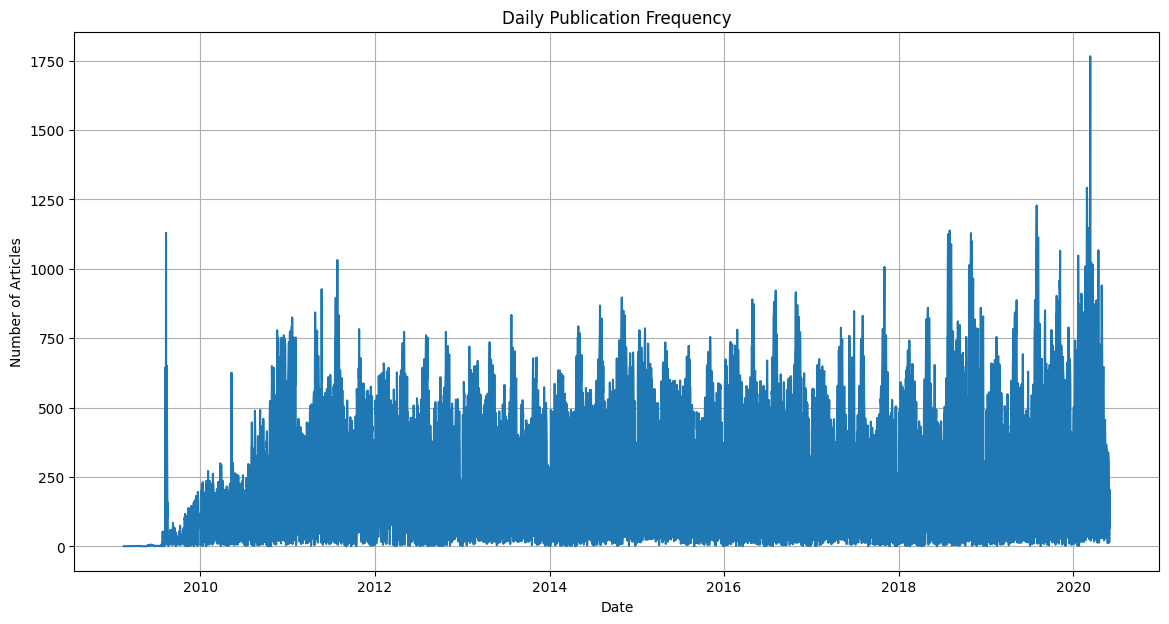

In [16]:
plt.figure(figsize=(14, 7))
daily_counts.plot()
plt.title('Daily Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

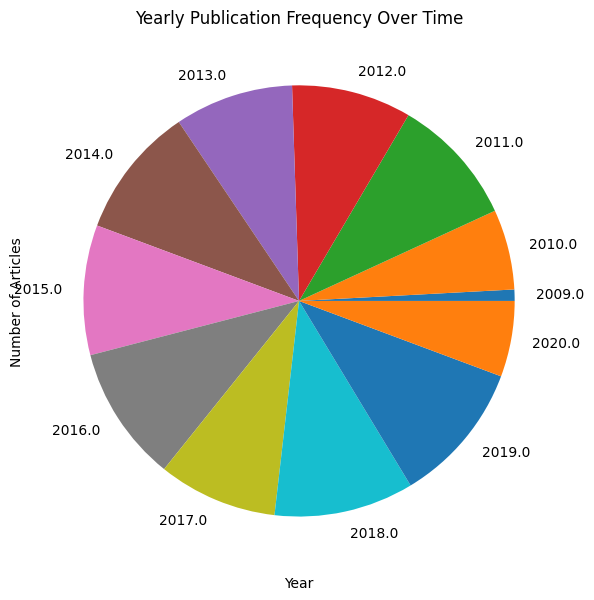

In [23]:
yearly_count = data.groupby(data['date'].dt.year).size()

plt.figure(figsize=(14, 7))
yearly_count.plot(kind='pie')
plt.title('Yearly Publication Frequency Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

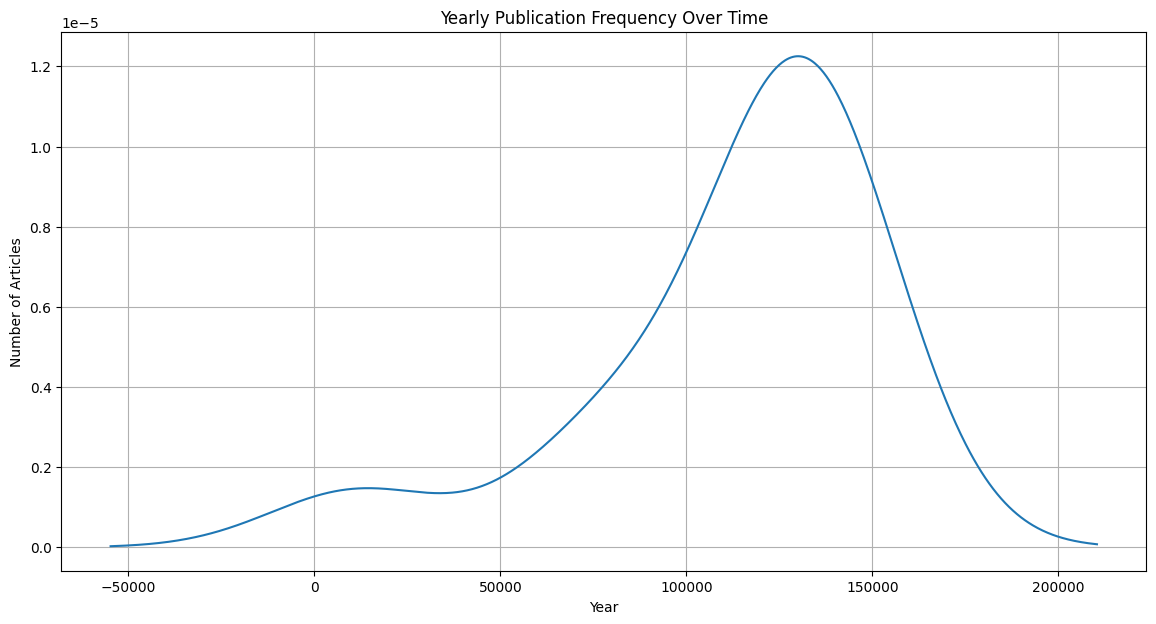

In [24]:
yearly_count = data.groupby(data['date'].dt.year).size()

plt.figure(figsize=(14, 7))
yearly_count.plot(kind = "density")
plt.title('Yearly Publication Frequency Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()